In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import ParameterGrid
import random
from collections import Counter

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  print('Not connected to TPU')
else:
  print("Connected to TPU")

Not connected to TPU


In [5]:
from google.colab import files
uploaded = files.upload()

Saving a3_train_final.tsv to a3_train_final.tsv
Saving a3_test.tsv to a3_test.tsv


In [7]:
# Read the TSV file
df = pd.read_csv("a3_train_final.tsv", sep="\t", header=None)

# Add headers "label" and "text"
df.columns = ["label", "text"]

In [8]:
import re

count_minus_one_alone = sum(df['label'].str.match(r'^-1$'))
count_minus_one_with_other = sum(df['label'].str.contains(r'-1/(?=\d)', regex=True))

print("Number of occurrences of -1 alone in the label column:", count_minus_one_alone)
print("Number of occurrences of -1 combined with another number in the label column:", count_minus_one_with_other)

Number of occurrences of -1 alone in the label column: 0
Number of occurrences of -1 combined with another number in the label column: 152


In [9]:
# Function to process labels
def process_labels(label):
    label_list = label.split("/")
    label_list = [l for l in label_list if l != "-1"]  # Drop -1 labels
    if len(label_list) == 1:
        return label_list[0]  # Return the single label
    else:
        counter = Counter(label_list)
        max_vote = max(counter.values())
        majority_labels = [l for l, count in counter.items() if count == max_vote]
        return random.choice(majority_labels)  # Randomly choose from majority labels

In [10]:
# Apply label processing
df['final_label'] = df['label'].apply(process_labels)

In [11]:
# Drop duplicates based on the "text" column
final_df= df.drop_duplicates(subset=['text'])

# Create a DataFrame containing only the dropped rows
dropped_rows_df = df[~df.index.isin(final_df.index)]

# Print the DataFrame with dropped duplicates
print("DataFrame with dropped duplicates:")
print(final_df)

# Print the DataFrame containing dropped rows
print("\nDataFrame containing dropped rows:")
print(dropped_rows_df)

DataFrame with dropped duplicates:
      label                                               text final_label
0       1/1   I'll only consume if I know what's inside it....           1
1      0/-1   It is easier to fool a million people than it...           0
2       0/0   NATURAL IMMUNITY  protected us since evolutio...           0
3      0/-1   NATURAL IMMUNITY  protected us since evolutio...           0
4       0/0   Proud to have resisted. Proud of my husband, ...           0
...     ...                                                ...         ...
50063   0/0  🤣 keep your 💩 I already know 3 people who have...           0
50064   0/0  🤣🤣🤣 "JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...           0
50065   0/0  🤣🤣🤣 I took the Vaccine because of work. If I d...           0
50066   0/0  🤨there's people already having severe side eff...           0
50067   1/1  🥦I ❤my covid vaccines and I'm so excited for m...           1

[50062 rows x 3 columns]

DataFrame containing dropped rows:
   

In [12]:
final_df = final_df.reset_index(drop=True)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = int(self.data.iloc[idx]['final_label'])  # Convert label to integer
        encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
# Splitting into train (60%), validation (20%), and test (20%)
train_df, temp_df = train_test_split(final_df, test_size=0.4, random_state=69)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=69)

# Resetting index for each subset
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [16]:
# Create DataLoader objects
train_dataset = CustomDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = CustomDataset(validation_df)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = CustomDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [17]:
#Define hyperparameters
learning_rate = 5e-5
batch_size = 16
num_epochs = 5

# Fine-tuning BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer for BERT models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Epoch 0, Batch 0/3755, Loss: 0.7413256168365479
Epoch 0, Batch 500/3755, Loss: 0.4089013338088989
Epoch 0, Batch 1000/3755, Loss: 0.6838806867599487
Epoch 0, Batch 1500/3755, Loss: 0.23491059243679047
Epoch 0, Batch 2000/3755, Loss: 0.22233963012695312
Epoch 0, Batch 2500/3755, Loss: 0.1511075496673584
Epoch 0, Batch 3000/3755, Loss: 0.14209584891796112
Epoch 0, Batch 3500/3755, Loss: 0.26481127738952637
Epoch 1, Batch 0/3755, Loss: 0.14880740642547607
Epoch 1, Batch 500/3755, Loss: 0.09539441764354706
Epoch 1, Batch 1000/3755, Loss: 0.38325515389442444
Epoch 1, Batch 1500/3755, Loss: 0.18605664372444153
Epoch 1, Batch 2000/3755, Loss: 0.06443983316421509
Epoch 1, Batch 2500/3755, Loss: 0.5200985670089722
Epoch 1, Batch 3000/3755, Loss: 0.27705174684524536
Epoch 1, Batch 3500/3755, Loss: 0.2518249750137329
Epoch 2, Batch 0/3755, Loss: 0.17197492718696594
Epoch 2, Batch 500/3755, Loss: 0.080318883061409
Epoch 2, Batch 1000/3755, Loss: 0.669279932975769
Epoch 2, Batch 1500/3755, Loss: 0.

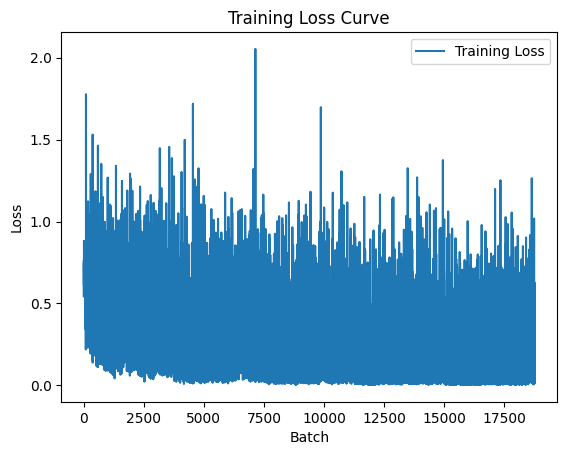

In [18]:
import matplotlib.pyplot as plt

# Define log_interval
log_interval = 500

# Lists to store losses
train_losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())

        # Print or log the loss if needed
        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')

# Plot the loss curve
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


In [19]:
# Evaluate on the validation set
model.eval()
val_predictions = []
val_targets = []
for batch in val_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        val_predictions.extend(preds.cpu().numpy())
        val_targets.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_targets, val_predictions)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.8485817019576508


In [20]:
# Evaluate on the test set
test_predictions = []
test_targets = []
for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_predictions.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save_pretrained("best_bert_model")

Test Accuracy: 0.8496953959852193
